# Finding the Happiness Factor
For our CMSC320 class our team did exploratory analysis on the World Happiness Report for 2021 and the World Development Indicators to determine what development factors best correspond with increased happiness across the globe
- Project by Victor Novichkov, Jacob Livchitz

### Downloading the datasets
- Need to have Python installed
- Recommended to install the kaggle pip library
    - ```pip install kaggle```
- Copy the commands listed under the datasets

### Datasets Used
[World Development Indicators - World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators) (~200MB at time of writing)
- How to download
    - Go to the **Data & Resources** tab
    - Download the **CSV**

[World Happiness Report 2021 - Ajaypal Singh](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021) (155KB at time of writing)
- How to download
    - ```kaggle datasets download -d ajaypalsinghlo/world-happiness-report-2021```


## Looking at the Happiest Countries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


whr_path = './world-happiness-index/whr.csv'
wdi_path = './world-development-index/WDIData_trimmed_n.csv'

whr_data = pd.read_csv(whr_path)
simplified_whr_data = whr_data[['Country Name', 'Life Ladder', 'Year']] # get just the name / score / and year

countries = pd.unique(simplified_whr_data['Country Name'])
print("Total Countries with Indices: {}".format(len(countries)))

wdi_data = pd.read_csv(wdi_path, index_col=0)

Total Countries with Indices: 166


In [69]:
print(simplified_whr_data[simplified_whr_data['Country Name'] == 'Rwanda']['Year'])

1455    2006
1456    2008
1457    2009
1458    2011
1459    2012
1460    2013
1461    2014
1462    2015
1463    2016
1464    2017
1465    2018
1466    2019
Name: Year, dtype: int64


## Dealing with Too Much Data
Although the World Bank dataset is amazing, its size is a bit too much for Github to even accept. In order to be able to collaborate we had to cut how much data we were working with. Luckily, there were a couple methods we could use to cut our dataset in half without drastically influencing our analysis
- Get rid of countries in the World Development Index data that don't have corresponding happiness indices
- Get rid of majority NaN/Null datapoints (we won't be looking at them in our analysis)
    - Note: The World Happiness Index started in 2012, which means most of the data in the World Development Index going back to 1960 isn't entirely relevant. As a result we can look for rows that have at least 20 non null entries (1990-2020).

```python
# Creating the truncated dataset
wdi_data = pd.read_csv(wdi_path)

# First by removing countries that don't have indices
boolean_mask = wdi_data['Country Name'].isin(countries)
wdi_cleaned = wdi_data[boolean_mask]
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/len(wdi_data)))*100))

# Remove all data from 1960 - 1999 (Most of the data from before the the Happiness Index even existed)
wdi_pre_drop = len(wdi_cleaned.columns)
wdi_cleaned.drop(axis=1, labels=wdi_cleaned.columns[4:44], inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (wdi_pre_drop/len(wdi_cleaned.columns)))*100))

# Get rid of all rows that have less than 8 datapoints over the time period from (2000-2020)
pre_dropna = len(wdi_cleaned)
wdi_cleaned.dropna(axis=0, thresh=8, inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/pre_dropna)) * 100))

# wdi_cleaned.to_csv('./world-development-index/WDIData_trimmed_n.csv')
```

Since the original dataset could not be uploaded. We can't show the comparison live

But we were able to trim 44.7% of the data just by removing countries without Happiness Indices

And trim a further 45.45% of the data by removing the datapoints from (1960 - 1989), leaving only 1990-2020

And trim an additional 15.99% of the data, dropping our final file size to ~ 27 MB

In [70]:
sample_code = "EG.CFT.ACCS.ZS"

# Gets Country Name, Country Code, Year, Indicator Value, Score
def getAllForIndicator(df, hi, indicator_code):
    
    countries = df[df['Indicator Code'] == indicator_code].copy()
    countries.drop(axis=1, labels=['Indicator Name', 'Indicator Code'], inplace=True)
    countries = pd.melt(countries, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='indicator_value')
    countries = countries.astype({'Year': np.int64})

    return countries.merge(hi, how='inner', on=['Country Name', 'Year']).dropna()


#print(combined)


[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


{'bodies': [<matplotlib.collections.PolyCollection at 0x2cd10a83280>,
 'cmeans': <matplotlib.collections.LineCollection at 0x2cd10a83190>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2cd10a8abb0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2cd10a8aca0>,
 'cbars': <matplotlib.collections.LineCollection at 0x2cd106e6b80>}

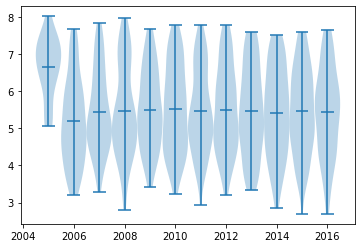

In [71]:
#Firstly, we will see if happiness has changed over time.
ipc_code = "EG.CFT.ACCS.ZS"
incomePerCap=getAllForIndicator(wdi_data, simplified_whr_data, ipc_code)
years=[]
for x,row in incomePerCap.iterrows():
    years.append(row.Year)
years=list(set(years))
years.sort()
print(years)
happy_per_year=[]
for yearIndex in years:
    currentYear=[]
    for x,row in incomePerCap.iterrows():
        if row.Year==yearIndex:
            currentYear.append(row['Life Ladder'])
    happy_per_year.append(currentYear)
   
plt.violinplot(happy_per_year,years,widths=1,showmeans=True)

35.9251026035469


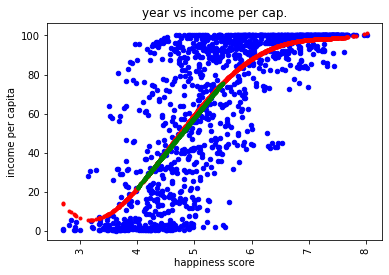

In [72]:
#When one thinks of happiness they think of money. Lets first graph the WHR dataset's graph of national income per capita vs happiness

ax=incomePerCap.plot.scatter(x='Life Ladder',xlabel='happiness score',y='indicator_value',ylabel='income per capita', rot=90,color='b',title='year vs income per cap.')
x=incomePerCap['Life Ladder']
y=incomePerCap['indicator_value']
z=np.polyfit(x,y,4)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')

x1=4
x2=5.5
y1=eq(4)
y2=eq(5.5)
slope=(y2-y1)/(x2-x1)

x=x[x>=4]
x=x[x<=5.5]
plt.plot(x,x*slope+(y1-slope*x1),'.',color='green')
print(slope)

We want to look at the data in general, correlations are cool

In [73]:
# Overall

plt.figure(figsize =(1,25))

def getAllIndicators(df, hi):
    
    mean_data = df.fillna(0).groupby(by='Indicator Code').mean().transpose()
    # mean_data.drop(mean_data.columns[60:], inplace=True, axis=1)
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    mean_happiness_data = hi.groupby(by='Year').mean().reset_index(level=[0])

    return mean_data.merge(mean_happiness_data, how='inner', on=['Year'])

    # print(pd.unique(df['Indicator Code']))

#indicator_data = getAllIndicators(wdi_data, simplified_whr_data)
#m,b = np.polyfit(indicator_data['Year'], indicator_data['Life Ladder'], 1)
#adjusted_corr = indicator_data.corr() * (1/m)

#hi_idx = adjusted_corr.columns.get_loc('Life Ladder')
#sns.heatmap(adjusted_corr.sort_values(by='Life Ladder', ascending=False).iloc[0:len(adjusted_corr):10, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')
print(getAllIndicators(wdi_data, simplified_whr_data).iloc[:,:4])
#data = getAllIndicators(wdi_data, simplified_whr_data).corr()
#hi_idx = data.columns.get_loc('Life Ladder')
#sns.heatmap(getAllIndicators(wdi_data, simplified_whr_data).corr().iloc[:50,hi_idx:hi_idx+1],center = 0, cmap='coolwarm')

    Year  AG.AGR.TRAC.NO  AG.CON.FERT.PT.ZS  AG.CON.FERT.ZS
0   2005   251454.018868        1476.415910      279.793774
1   2006   197344.830189        1256.634124      308.678894
2   2007   163599.886792        1447.631173      273.640838
3   2008    68414.433962        1075.084266      299.860978
4   2009    60111.660377        1008.337866      175.996372
5   2010        0.000000         391.660340      189.343016
6   2011        0.000000         460.081335      226.630671
7   2012        0.000000         454.426518      217.239530
8   2013        0.000000         398.970349      222.096264
9   2014        0.000000         516.067436      200.646773
10  2015        0.000000         805.046937      191.372752
11  2016        0.000000         840.666724      186.249745
12  2017        0.000000         530.418211      186.340349
13  2018        0.000000         517.797156      190.255614
14  2019        0.000000           0.000000        0.000000
15  2020        0.000000           0.000

<Figure size 72x1800 with 0 Axes>

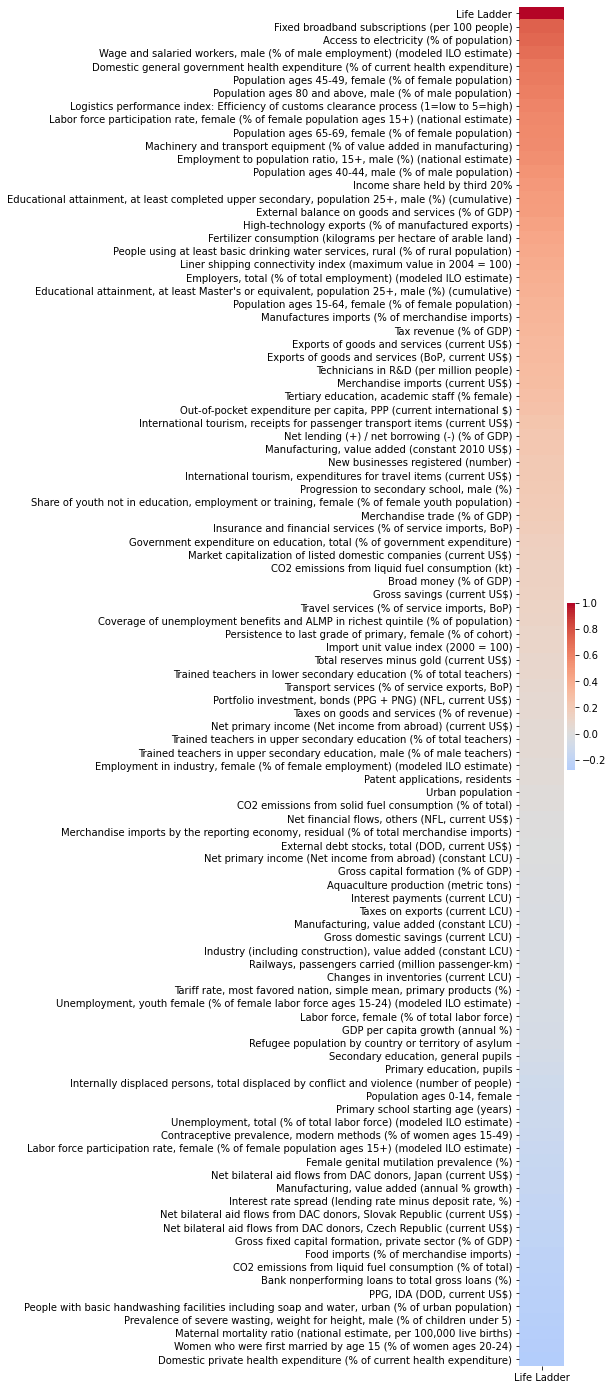

In [152]:
# Correlation for a specific year

plt.figure(figsize =(1,25))

def getAllIndicatorsPerCountryForYear(df, hi, year):
    
    mean_data = df[["Country Name", "Indicator Name", "Indicator Code", str(year)]].fillna(0)
    new_data_table = mean_data.pivot(index=['Indicator Name'],columns=['Country Name'], values=[str(year)]).T.fillna(0)
    mean_happiness_data = hi[hi['Year'] == year]

    return new_data_table.merge(mean_happiness_data, how='inner', on=['Country Name'])

new_corr = getAllIndicatorsPerCountryForYear(wdi_data, simplified_whr_data, 2016).corr()
hi_idx = new_corr.columns.get_loc('Life Ladder')
sns.heatmap(new_corr.sort_values(by='Life Ladder', ascending=False).iloc[0:len(adjusted_corr):10, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')

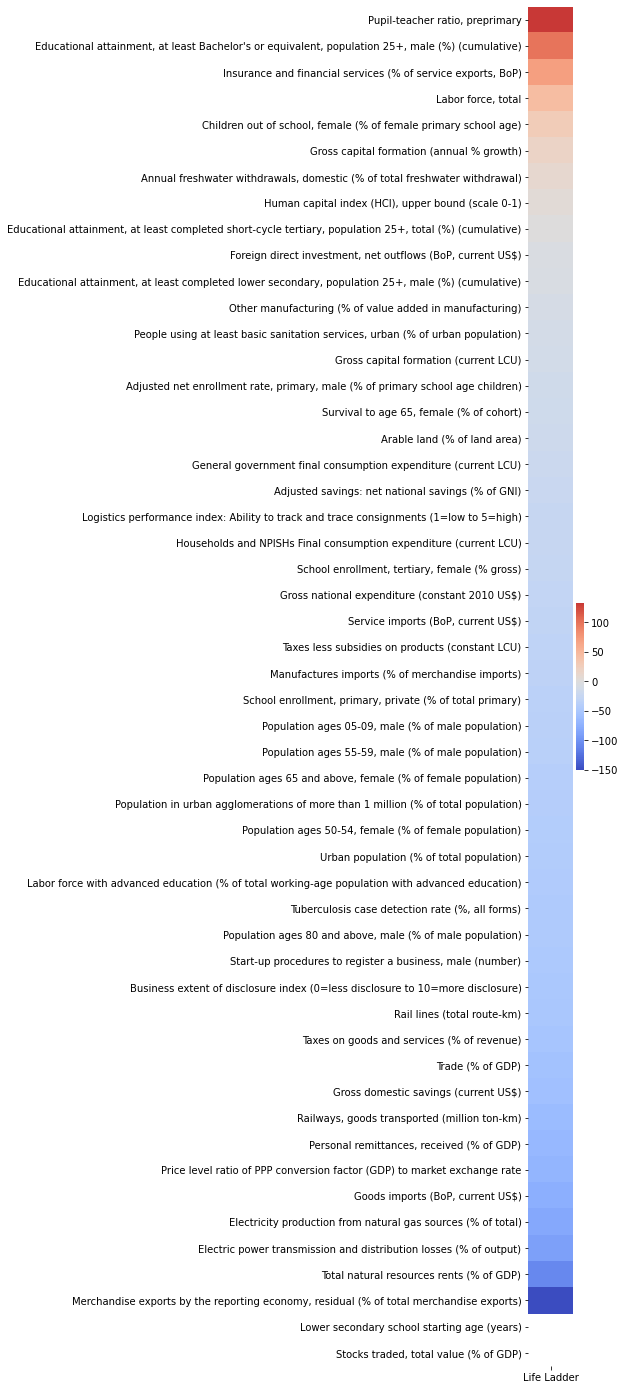

In [75]:
# For a specific country

plt.figure(figsize =(1,25))

def getAllIndicatorsForCountry(df, hi, country):

    mean_data = df[df['Country Name'] == country].fillna(0).groupby(by='Indicator Name').mean().transpose()
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    return mean_data.merge(hi[hi['Country Name'] == country].groupby(by='Year').mean(), how='inner', on=['Year'])

indicator_data = getAllIndicatorsForCountry(wdi_data, simplified_whr_data, 'Sweden')
m,b = np.polyfit(indicator_data['Year'], indicator_data['Life Ladder'], 1)
adjusted_corr = indicator_data.corr() * (1/m)

hi_idx = adjusted_corr.columns.get_loc('Life Ladder')
# getAllIndicators(wdi_data, simplified_whr_data, 'Sweden').corr()['Life Ladder'].sort_values(ascending=True)[:50]
sns.heatmap(adjusted_corr.sort_values(by='Life Ladder', ascending=False).iloc[0:len(adjusted_corr):20, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')